# Code for Project
# The Phase Transition in Random Graphs
## CS648: Course Project
2024-25-II

> Pradeep Chahal (210733) \
Havish (220879)

Experimentation on random graphs to observe behaviour around values of p

---


# 1. When does the graph becomes connected?
We run simulations across different values of p to observe how likely the graph is to be fully connected.

For a range of values of p, we run several trials and aggregate the results into a graph. The graph plots the `ratio of the number of times the graph was connected` versus `p`.

* We use an optimized Union-Find (Disjoint Set Union) structure for efficiency
* We use `numpy` arrays for faster memory access
* We apply `njit` from `numba` for just-in-time (JIT) compilation to speed up execution

In [31]:
import numpy as np
from numba import njit
import math
import matplotlib.pyplot as plt

@njit
def init_dsu(n):
    parent = np.arange(n)
    rank = np.zeros(n, dtype=np.int32)
    return parent, rank

@njit
def find(x, parent):
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x

@njit
def union(x, y, parent, rank):
    xr, yr = find(x, parent), find(y, parent)
    if xr == yr:
        return 0
    if rank[xr] < rank[yr]:
        parent[xr] = yr
    else:
        parent[yr] = xr
        if rank[xr] == rank[yr]:
            rank[xr] += 1
    return 1

@njit
def is_connected_gnp(n, p):
    parent, rank = init_dsu(n)
    components = n
    for u in range(n):
        for v in range(u + 1, n):
            if np.random.random() < p:
                if union(u, v, parent, rank):
                    components -= 1
                    if components == 1:
                        return True
    return components == 1

@njit
def run_trials(n, p, num_trials):
    count = 0
    for _ in range(num_trials):
        if is_connected_gnp(n, p):
            count += 1
    return count


# Run
n = 1000
num_trials = 100

# Coarse steps in the lower range
p_range1 = np.linspace(0.000, 0.004, 5)
# Medium in the transition range
p_range2 = np.linspace(0.004, 0.012, 40)
# Fine-grained in the range to care about
p_range3 = np.linspace(0.012, 0.05, 20)

# Concatenate, then remove duplicates (if any)
p_values = np.unique(np.concatenate((p_range1, p_range2, p_range3)))
connect_counts_frac = np.zeros_like(p_values)

for i, p in enumerate(p_values):
    print(f"Testing p={p:.5f} ...", end='\r')
    if p in p_range2:
        num_trials = 500
    else:
        num_trials = 100
    connect_counts_frac[i] = run_trials(n, p, num_trials) / num_trials


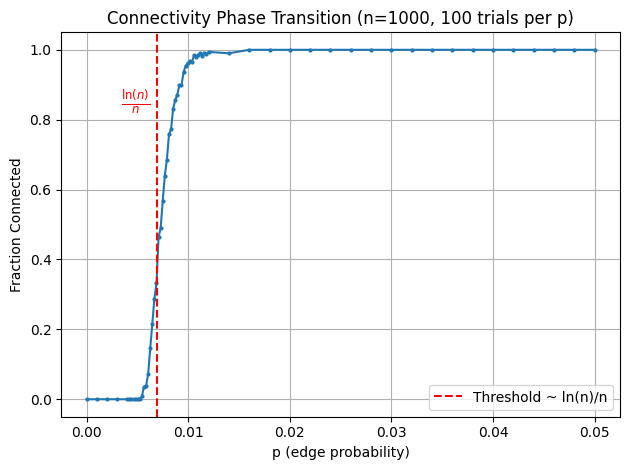

In [41]:
# Plotting the phase transition
plt.plot(p_values, connect_counts_frac, marker='o', markersize=2)
threshold = math.log(n) / n
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold ~ ln(n)/n')
plt.text(threshold - 0.0035, 0.83, r'$\frac{\ln(n)}{n}$', color='red', fontsize=12)  # Adjust the position as needed
plt.title(f"Connectivity Phase Transition (n={n}, 500 trials per p)")
plt.xlabel("p (edge probability)")
plt.ylabel("Fraction Connected")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-43-32f17fcc98b3>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


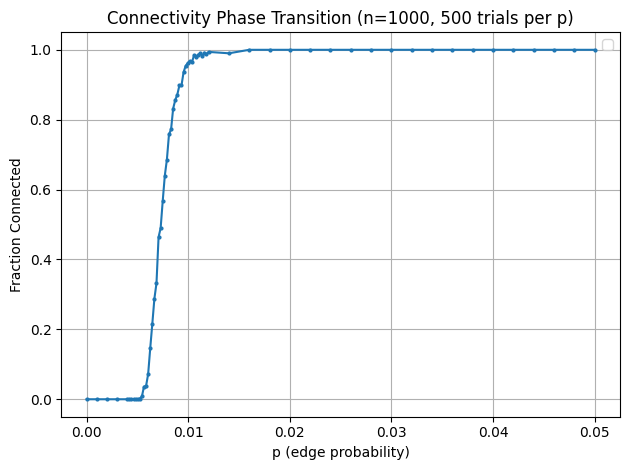

In [43]:
# Plotting the phase transition
plt.plot(p_values, connect_counts_frac, marker='o', markersize=2)
plt.title(f"Connectivity Phase Transition (n={n}, 500 trials per p)")
plt.xlabel("p (edge probability)")
plt.ylabel("Fraction Connected")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



---


# 2. Size of Connected Components

The random graph G(n, p) undergoes a remarkable phase transition around the edge probability p(n) = 1/n.

*The meaning of* ***whp*** *?

[n --> inf]

## Plots


🔴 Processing n=10 (ε=0.2000, trials=100)
p_sub=0.080000, p_super=0.120000
✅ Subcritical: 3.5 ± 1.5
✅ Supercritical: 5.1 ± 2.1

🔴 Processing n=100 (ε=0.2000, trials=50)
p_sub=0.008000, p_super=0.012000
✅ Subcritical: 11.6 ± 5.0
✅ Supercritical: 33.0 ± 13.7

🔴 Processing n=1000 (ε=0.2857, trials=20)
p_sub=0.000714, p_super=0.001286
✅ Subcritical: 21.8 ± 7.6
✅ Supercritical: 401.5 ± 84.6

🔴 Processing n=10000 (ε=0.1459, trials=10)
p_sub=0.000085, p_super=0.000115
✅ Subcritical: 91.1 ± 23.0
✅ Supercritical: 2236.7 ± 359.0

🔴 Processing n=100000 (ε=0.1000, trials=10)
p_sub=0.000009, p_super=0.000011
✅ Subcritical: 323.2 ± 61.2
✅ Supercritical: 18291.0 ± 1125.9

🔴 Processing n=1000000 (ε=0.1000, trials=2)
p_sub=0.000001, p_super=0.000001
✅ Subcritical: 365.0 ± 10.0
✅ Supercritical: 178117.5 ± 4204.5

📊 Final Results:
n        ε        Subcritical          Supercritical       
10       0.2000  3.5 ± 1.5        5.1 ± 2.1
100      0.2000  11.6 ± 5.0        33.0 ± 13.7
1000     0.2857  21.8 ± 7

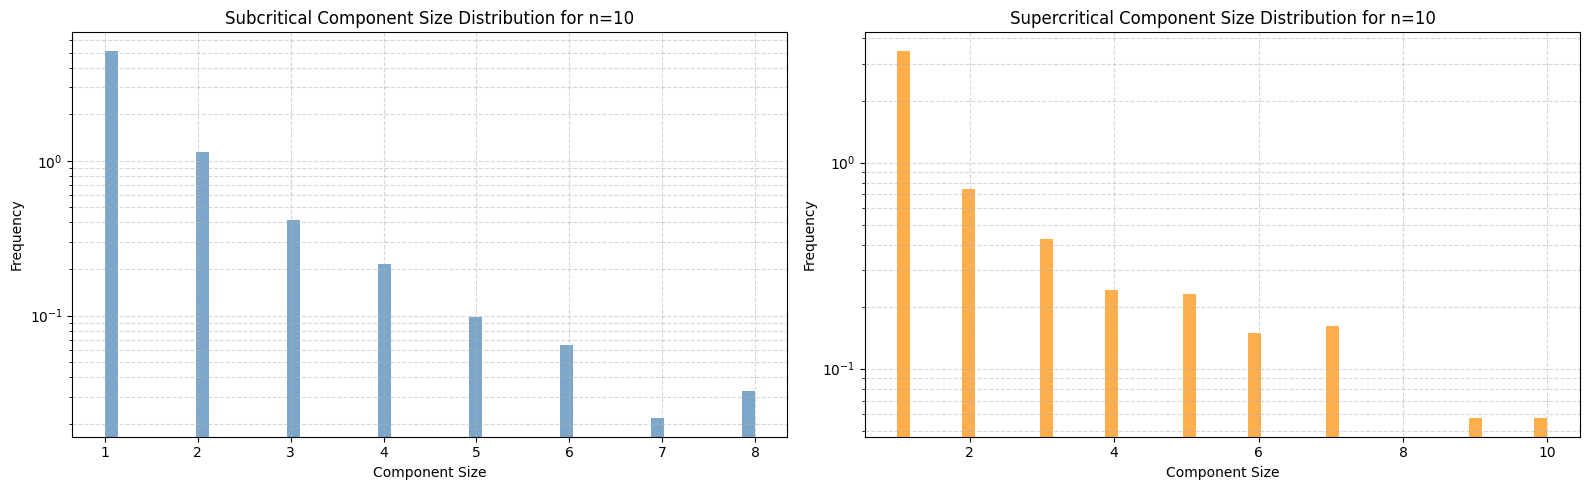

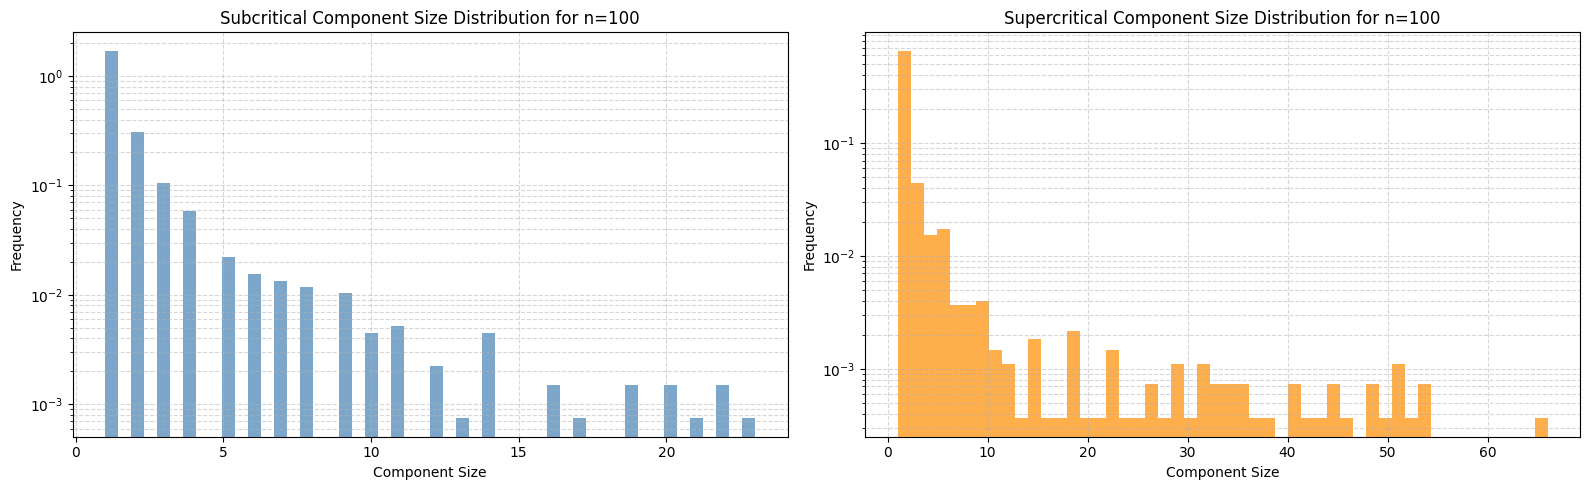

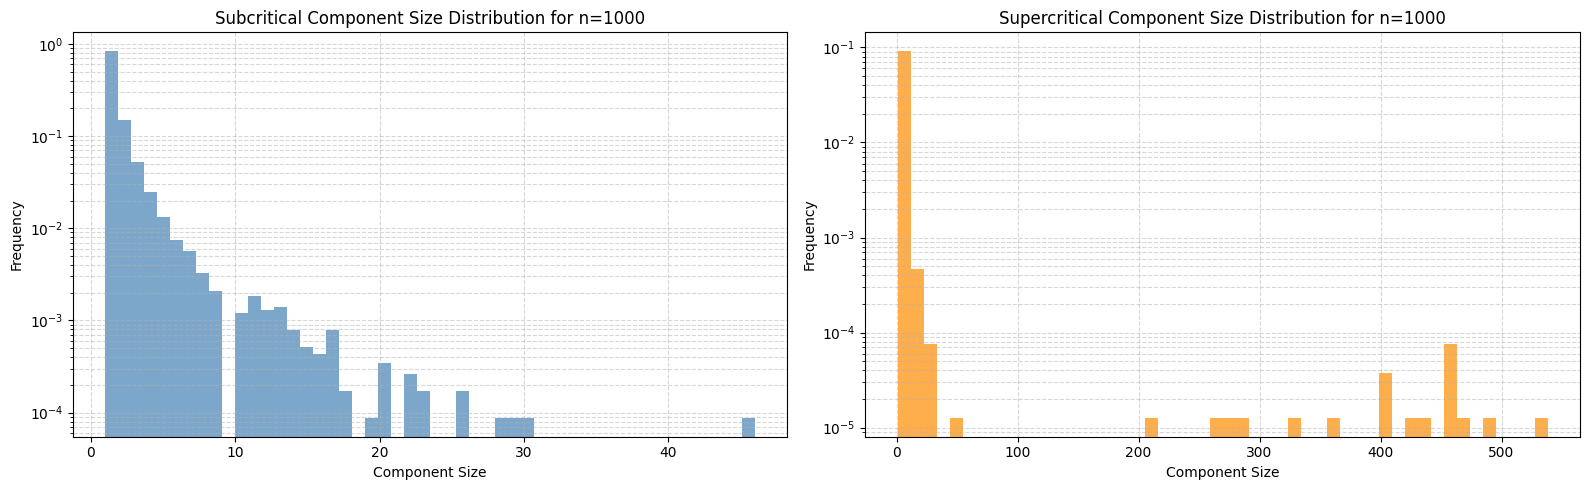

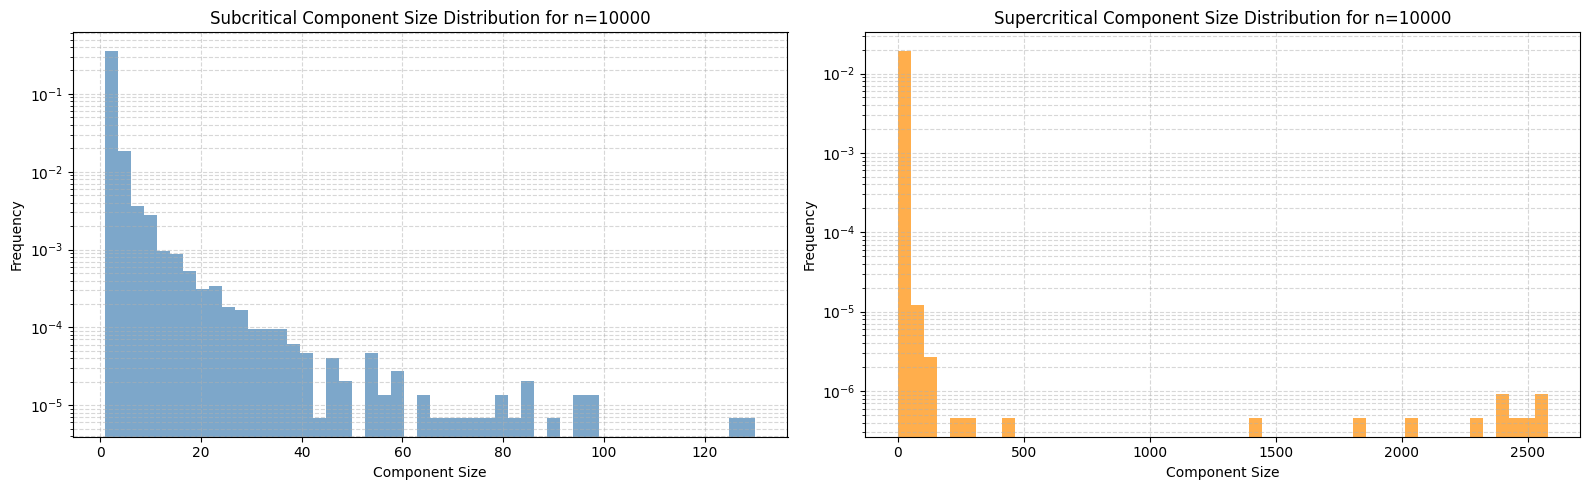

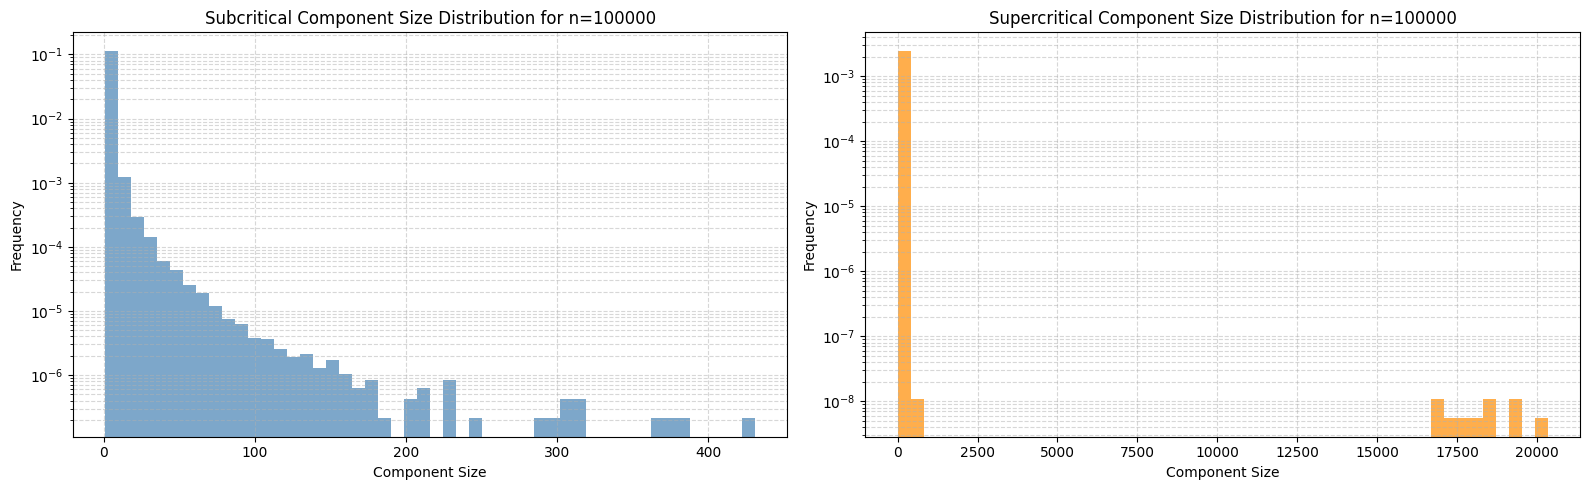

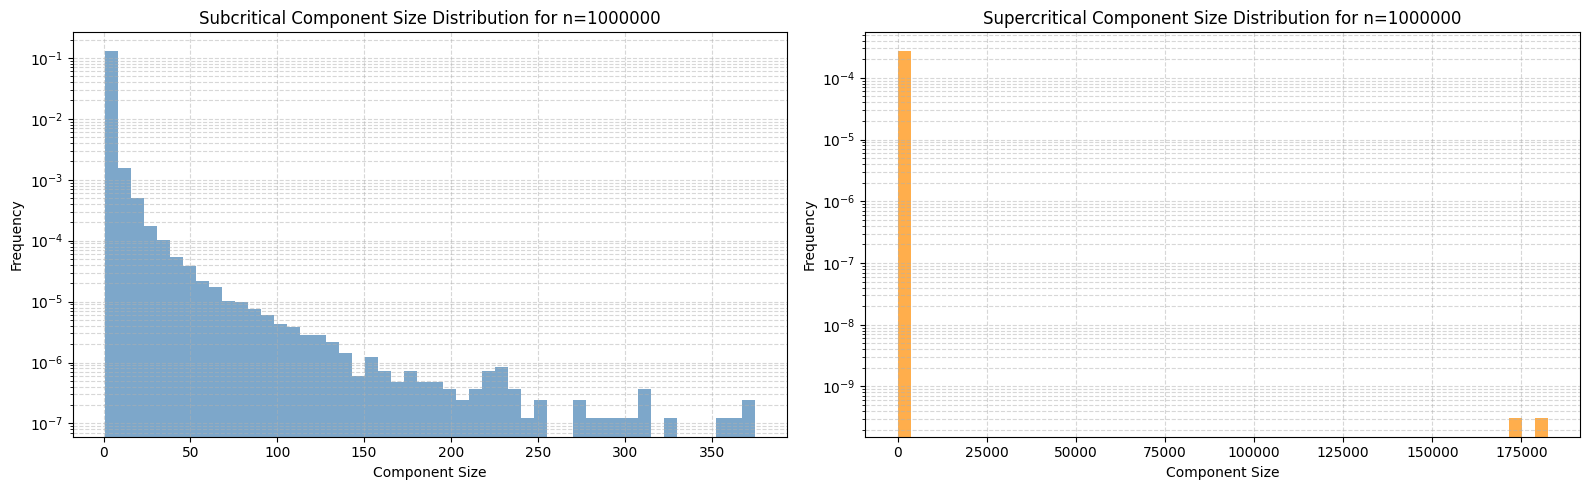

In [1]:
import numpy as np
from numba import njit
from joblib import Parallel, delayed

@njit
def find(x, parent):
    """Path-compressed find"""
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x

@njit
def sample_without_replacement(start, count, k):
    """Efficient sampling without replacement (Numba-compatible)"""
    pool = np.arange(start, start + count)
    for i in range(k):
        j = i + np.random.randint(count - i)
        pool[i], pool[j] = pool[j], pool[i]
    return pool[:k]

@njit(nogil=True)
def simulate_all_components(n, p):
    parent = np.arange(n)
    size = np.ones(n)

    for u in range(n - 1):
        possible = n - u - 1
        if possible <= 0:
            continue
        k = np.random.binomial(possible, p)
        if k == 0:
            continue

        neighbors = sample_without_replacement(u + 1, possible, k)
        for v in neighbors:
            x = find(u, parent)
            y = find(v, parent)
            if x != y:
                if size[x] < size[y]:
                    x, y = y, x
                parent[y] = x
                size[x] += size[y]

    # Compress all paths and compute final component sizes
    for i in range(n):
        parent[i] = find(i, parent)
    component_sizes = {}
    for i in range(n):
        root = parent[i]
        if root in component_sizes:
            component_sizes[root] += 1
        else:
            component_sizes[root] = 1

    return np.array(list(component_sizes.values()))


def compute_epsilon(n):
    """Compute ε for given n"""
    if n in {10, 100}:
        return 0.2
    if n in {10**5, 10**6}:
        return 0.1
    return 1.5 * (np.log(n) ** (1/3)) * (n ** (-1/3))

def simulate_components_batch(n, p, batch_size):
    return [simulate_all_components(n, p) for _ in range(batch_size)]


def run_experiment():
    n_values = [10, 100, 1000, 10**4, 10**5, 10**6]
    trial_map = {10: 100, 100: 50, 1000: 20, 10**4: 10, 10**5: 10, 10**6: 2}
    results = {}

    for n in n_values:
        ε = compute_epsilon(n)
        p_sub = max(0.0, (1 - ε) / n)
        p_super = min(1.0, (1 + ε) / n)
        trials = trial_map[n]

        print(f"\n🔴 Processing n={n} (ε={ε:.4f}, trials={trials})")
        print(f"p_sub={p_sub:.6f}, p_super={p_super:.6f}")

        batch_size = 5 if trials >= 5 else 1
        num_batches = (trials + batch_size - 1) // batch_size

        # Run subcritical trials
        sub_batches = Parallel(n_jobs=-1)(
            delayed(simulate_components_batch)(n, p_sub, batch_size) for _ in range(num_batches)
        )
        sub_components = [c for batch in sub_batches for c in batch][:trials]
        super_batches = Parallel(n_jobs=-1)(
            delayed(simulate_components_batch)(n, p_super, batch_size) for _ in range(num_batches)
        )
        super_components = [c for batch in super_batches for c in batch][:trials]

        # Store results
        results[n] = {
            'ε': ε,
            'sub_mean': np.mean([np.max(s) for s in sub_components]),
            'sub_std': np.std([np.max(s) for s in sub_components]),
            'super_mean': np.mean([np.max(s) for s in super_components]),
            'super_std': np.std([np.max(s) for s in super_components]),
            'sub_components': sub_components,
            'super_components': super_components
        }

        print(f"✅ Subcritical: {results[n]['sub_mean']:.1f} ± {results[n]['sub_std']:.1f}")
        print(f"✅ Supercritical: {results[n]['super_mean']:.1f} ± {results[n]['super_std']:.1f}")

    # Final summary
    print("\n📊 Final Results:")
    print(f"{'n':<8} {'ε':<8} {'Subcritical':<20} {'Supercritical':<20}")
    for n in n_values:
        res = results[n]
        print(f"{n:<8} {res['ε']:.4f}  {res['sub_mean']:.1f} ± {res['sub_std']:.1f}        {res['super_mean']:.1f} ± {res['super_std']:.1f}")

    return results


# Execute
if __name__ == "__main__":
    results = run_experiment()


import matplotlib.pyplot as plt

def plot_component_distributions_side_by_side(results_dict, n):
    """
    Plot histograms of component sizes side by side for subcritical and supercritical phases.
    """
    # Extract the component sizes for both sub and supercritical cases
    sub_sizes = results_dict[n]['sub_components']
    super_sizes = results_dict[n]['super_components']

    # Flatten the component sizes for both sub and super
    sub_all_sizes = np.concatenate(sub_sizes)
    super_all_sizes = np.concatenate(super_sizes)

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    # Subcritical plot
    axs[0].hist(sub_all_sizes, bins=50, density=True, alpha=0.7, color='steelblue')
    axs[0].set_title(f"Subcritical Component Size Distribution for n={n}")
    axs[0].set_xlabel("Component Size")
    axs[0].set_ylabel("Frequency")
    axs[0].set_yscale("log")
    axs[0].grid(True, which='both', linestyle='--', alpha=0.5)

    # Supercritical plot
    axs[1].hist(super_all_sizes, bins=50, density=True, alpha=0.7, color='darkorange')
    axs[1].set_title(f"Supercritical Component Size Distribution for n={n}")
    axs[1].set_xlabel("Component Size")
    axs[1].set_ylabel("Frequency")
    axs[1].set_yscale("log")
    axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

for n in [10, 100, 1000, 10**4, 10**5, 10**6]:
    plot_component_distributions_side_by_side(results, n)


whp all connected components are of size at most 7/e^2 ln n

---



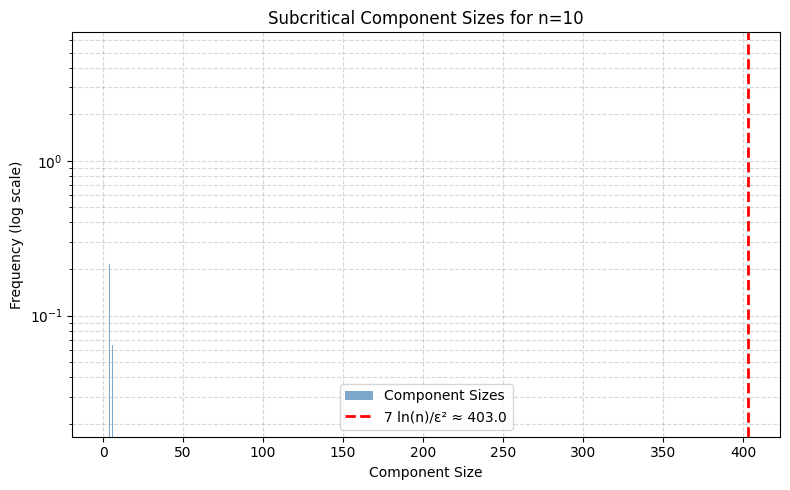

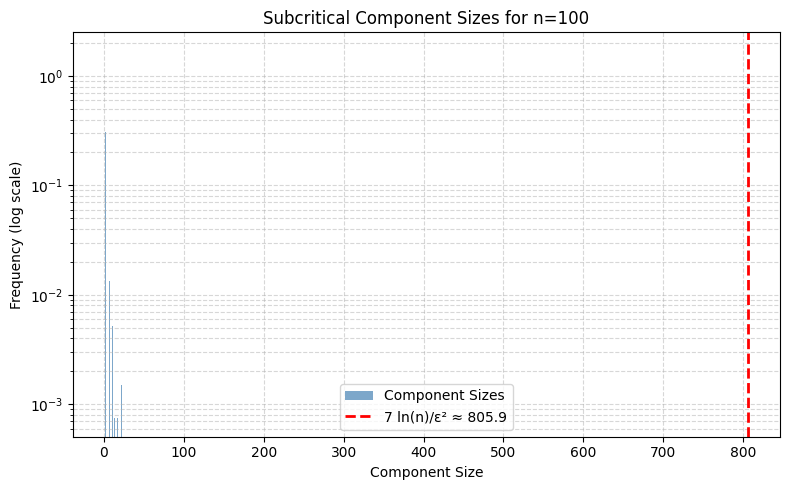

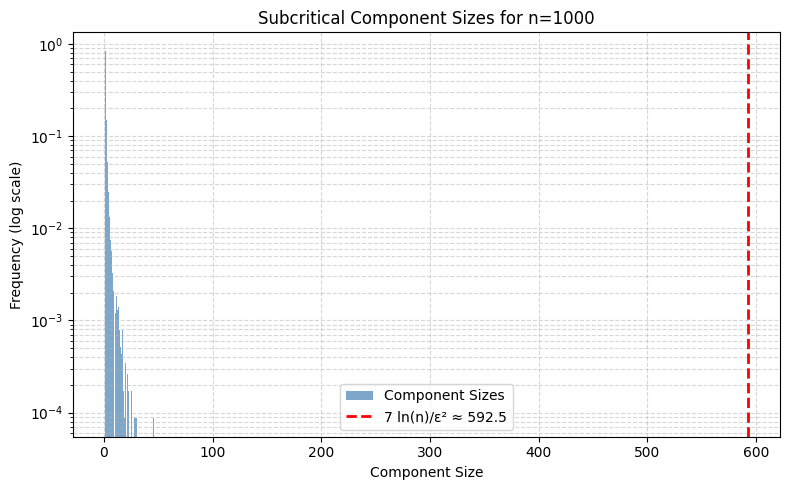

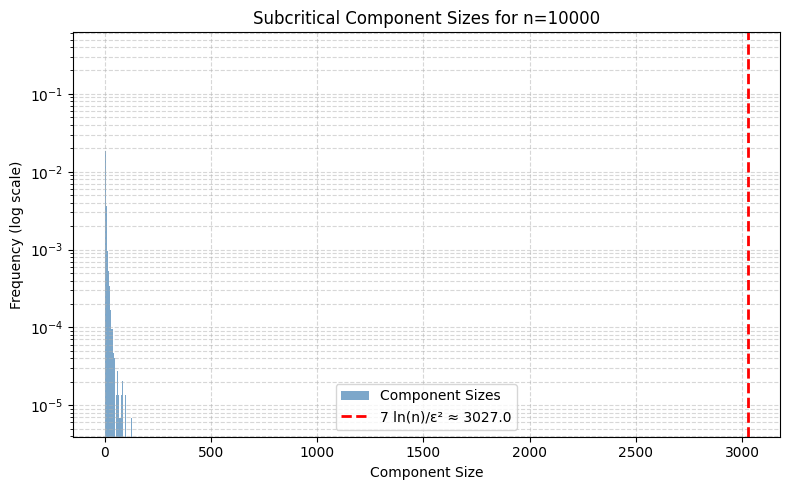

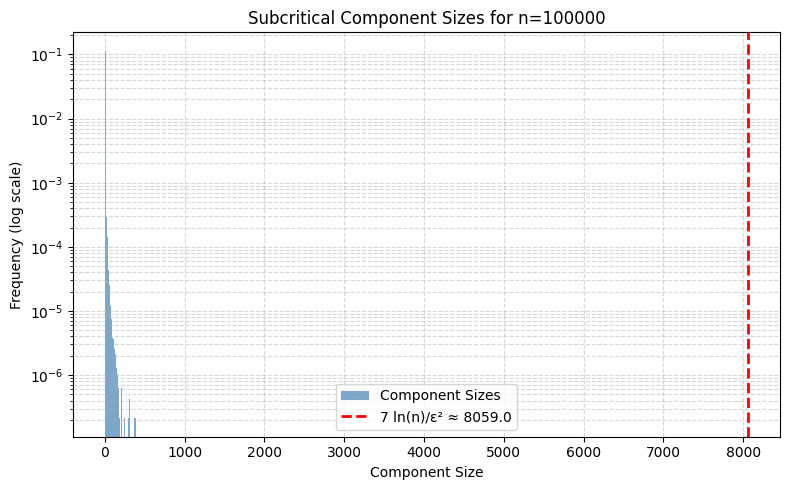

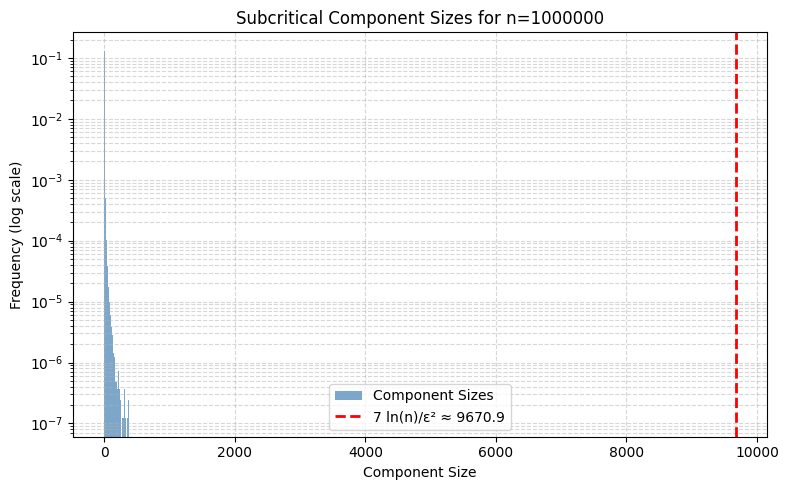

In [3]:
def subcritical_component_bound(n, epsilon):
    return (7 / (epsilon ** 2)) * np.log(n)

def extract_all_sub_sizes(results, n):
    return np.concatenate(results[n]['sub_components'])

import matplotlib.pyplot as plt

def plot_subcritical_with_bound(results, n):
    epsilon = results[n]['ε']
    sizes = extract_all_sub_sizes(results, n)
    bound = subcritical_component_bound(n, epsilon)

    plt.figure(figsize=(8, 5))
    plt.hist(sizes, bins=50, density=True, alpha=0.7, color='steelblue', label='Component Sizes')
    plt.axvline(bound, color='red', linestyle='--', linewidth=2, label=f'7 ln(n)/ε² ≈ {bound:.1f}')
    plt.title(f"Subcritical Component Sizes for n={n}")
    plt.xlabel("Component Size")
    plt.ylabel("Frequency (log scale)")
    plt.yscale("log")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

for n in [10, 100, 1000, 10**4, 10**5, 10**6]:
    plot_subcritical_with_bound(results, n)


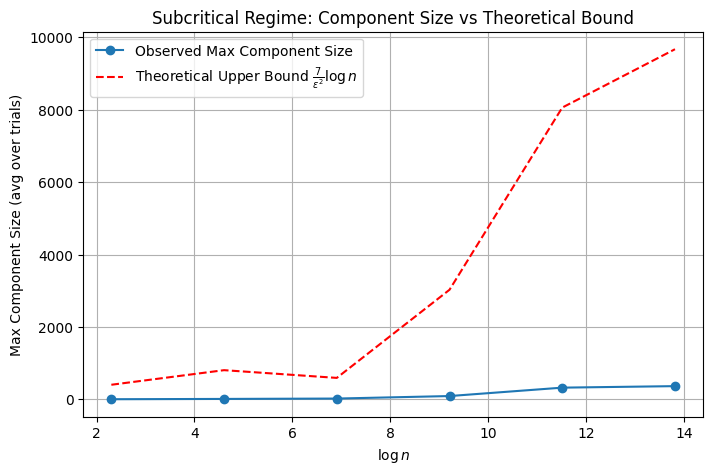

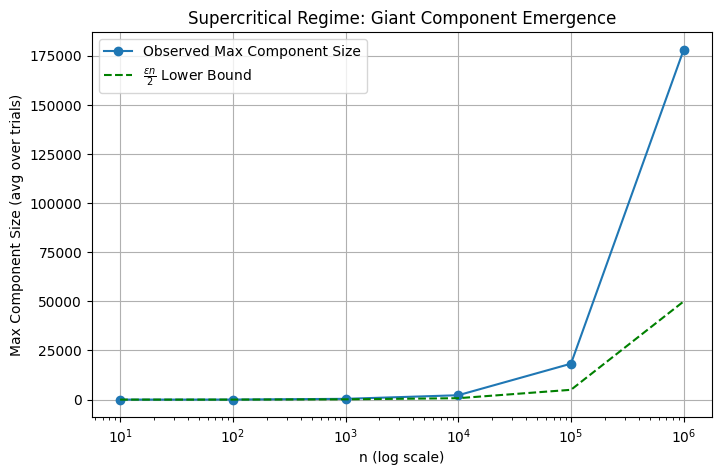

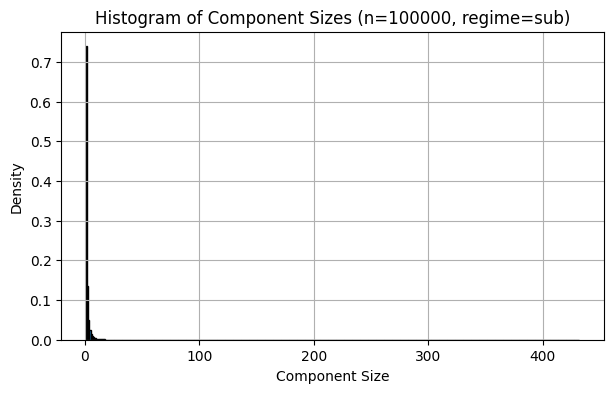

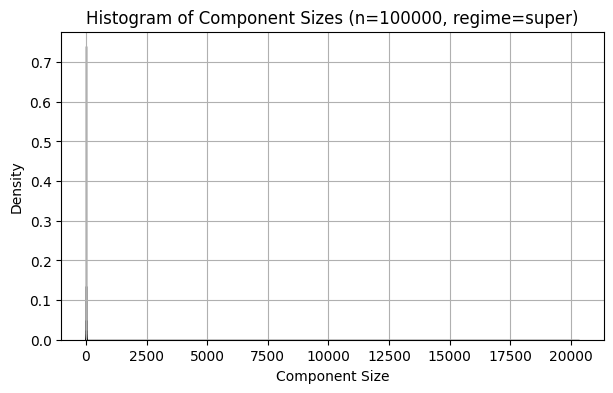

In [4]:
import matplotlib.pyplot as plt

def plot_subcritical_bound(results):
    ns = sorted(results.keys())
    max_comp_sizes = [results[n]['sub_mean'] for n in ns]
    epsilons = [results[n]['ε'] for n in ns]
    logs = [np.log(n) for n in ns]
    upper_bounds = [7 / eps**2 * np.log(n) for n, eps in zip(ns, epsilons)]

    plt.figure(figsize=(8, 5))
    plt.plot(logs, max_comp_sizes, 'o-', label='Observed Max Component Size')
    plt.plot(logs, upper_bounds, 'r--', label=r'Theoretical Upper Bound $\frac{7}{\epsilon^2} \log n$')
    plt.xlabel(r'$\log n$')
    plt.ylabel('Max Component Size (avg over trials)')
    plt.title('Subcritical Regime: Component Size vs Theoretical Bound')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_supercritical_giant(results):
    ns = sorted(results.keys())
    max_comp_sizes = [results[n]['super_mean'] for n in ns]
    epsilons = [results[n]['ε'] for n in ns]
    lower_bounds = [eps * n / 2 for n, eps in zip(ns, epsilons)]

    plt.figure(figsize=(8, 5))
    plt.plot(ns, max_comp_sizes, 'o-', label='Observed Max Component Size')
    plt.plot(ns, lower_bounds, 'g--', label=r'$\frac{\epsilon n}{2}$ Lower Bound')
    plt.xscale('log')
    plt.xlabel('n (log scale)')
    plt.ylabel('Max Component Size (avg over trials)')
    plt.title('Supercritical Regime: Giant Component Emergence')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_component_histogram(results, n_val, regime='sub'):
    comps = results[n_val][f'{regime}_components']
    all_sizes = np.concatenate(comps)

    plt.figure(figsize=(7, 4))
    plt.hist(all_sizes, bins=range(1, max(all_sizes)+2), density=True, edgecolor='black')
    plt.xlabel('Component Size')
    plt.ylabel('Density')
    plt.title(f'Histogram of Component Sizes (n={n_val}, regime={regime})')
    plt.grid(True)
    plt.show()

plot_subcritical_bound(results)
plot_supercritical_giant(results)
plot_component_histogram(results, 10**5, 'sub')
plot_component_histogram(results, 10**5, 'super')


### Demonstrating a random graph visually and phase transition

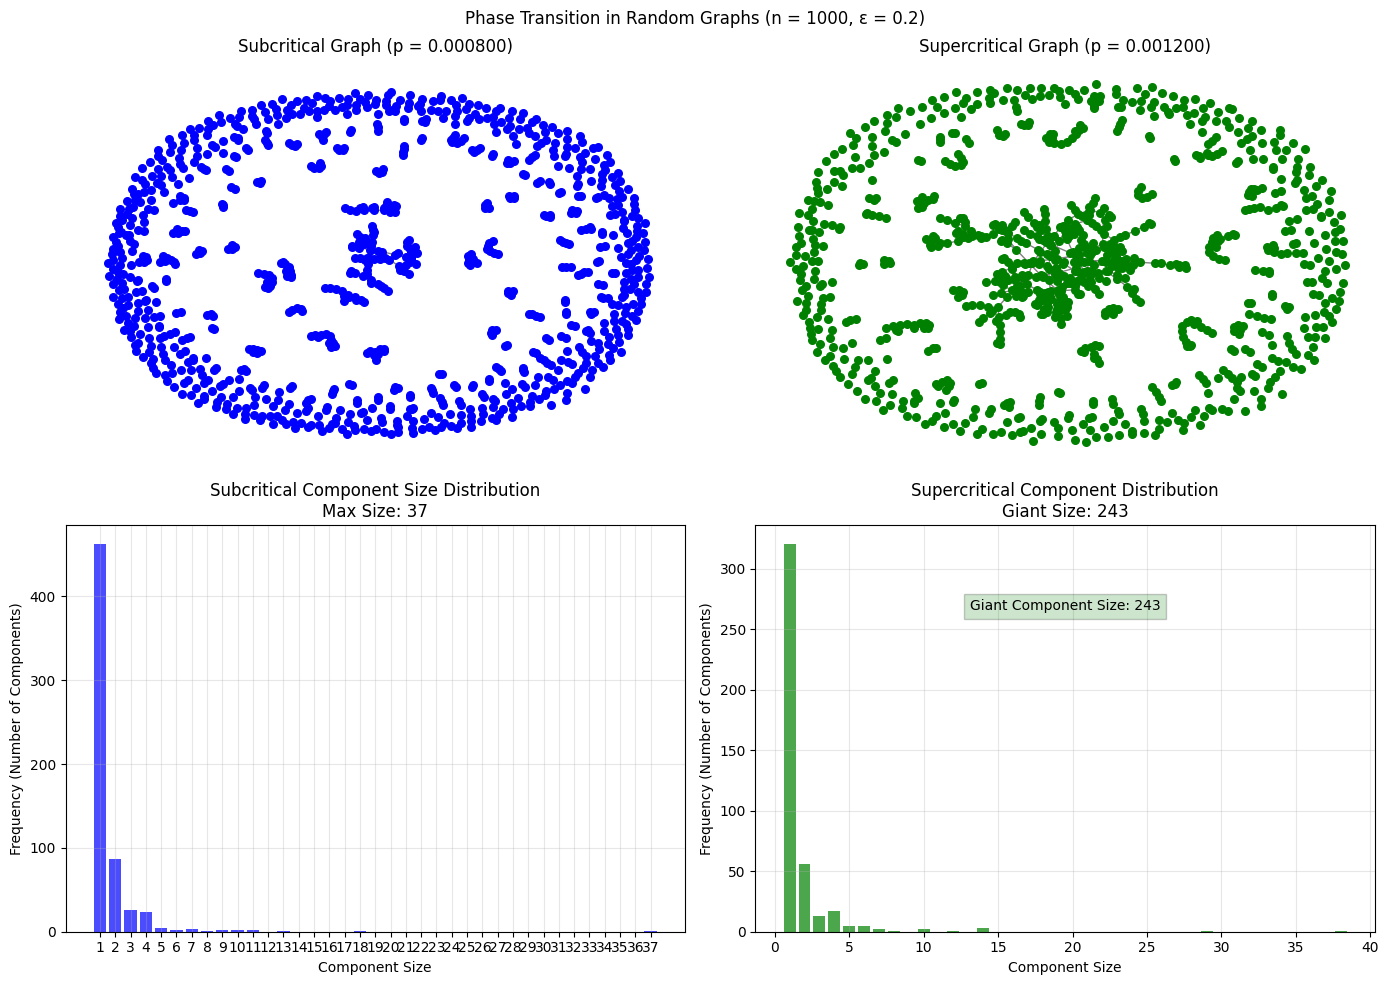

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Parameters
n = 1000  # Number of vertices
epsilon = 0.2  # Control how far from threshold

# Calculate probabilities
p1 = (1 - epsilon) / n  # Subcritical regime
p2 = (1 + epsilon) / n  # Supercritical regime

# Generate random graphs
G1 = nx.erdos_renyi_graph(n, p1, seed=42)
G2 = nx.erdos_renyi_graph(n, p2, seed=42)

# Create a figure with 2 rows, 2 columns
fig = plt.figure(figsize=(14, 10))

# Draw subcritical graph
plt.subplot(2, 2, 1)
pos1 = nx.spring_layout(G1, seed=42)
nx.draw(G1, pos1, node_size=30, node_color="blue", edge_color="gray", with_labels=False)
plt.title(f"Subcritical Graph (p = {p1:.6f})")

# Draw supercritical graph
plt.subplot(2, 2, 2)
pos2 = nx.spring_layout(G2, seed=42)
nx.draw(G2, pos2, node_size=30, node_color="green", edge_color="gray", with_labels=False)
plt.title(f"Supercritical Graph (p = {p2:.6f})")

# Calculate component sizes
comp_sizes1 = [len(c) for c in nx.connected_components(G1)]
comp_sizes2 = [len(c) for c in nx.connected_components(G2)]

# Use Counter to correctly count frequencies
comp_count1 = Counter(comp_sizes1)
comp_count2 = Counter(comp_sizes2)

# Plot histogram for subcritical component sizes - using bar for explicit control
plt.subplot(2, 2, 3)
plt.bar(list(comp_count1.keys()), list(comp_count1.values()), color='blue', alpha=0.7, width=0.8)
plt.xlabel('Component Size')
plt.ylabel('Frequency (Number of Components)')
plt.title(f'Subcritical Component Size Distribution\nMax Size: {max(comp_sizes1)}')
plt.grid(alpha=0.3)
plt.xticks(range(1, max(comp_sizes1) + 1))

# Plot histogram for supercritical component sizes
plt.subplot(2, 2, 4)
# If there's a giant component, highlight it
giant_size = max(comp_sizes2)
small_sizes = [s for s in comp_sizes2 if s < giant_size]
small_count = Counter(small_sizes)

# Plot small components
plt.bar(list(small_count.keys()), list(small_count.values()), color='green', alpha=0.7, width=0.8)

# Add text annotation for giant component
if giant_size > 5*max(small_sizes if small_sizes else [1]):
    plt.text(0.5, 0.8, f'Giant Component Size: {giant_size}',
             ha='center', va='center', transform=plt.gca().transAxes,
             bbox=dict(facecolor='green', alpha=0.2))

plt.xlabel('Component Size')
plt.ylabel('Frequency (Number of Components)')
plt.title(f'Supercritical Component Distribution\nGiant Size: {giant_size}')
plt.grid(alpha=0.3)

plt.suptitle(f'Phase Transition in Random Graphs (n = {n}, ε = {epsilon})')
plt.tight_layout()
plt.savefig('random_graph_transition_complete.png', dpi=300)
plt.show()


Graph becomes connected at p = ln n / n